In [17]:
import scipy.stats as ss
import matplotlib.pyplot as plt
import pandas as pd
import psycopg2 as pg
import os
import random
import time
import numpy as np

(array([14., 12.,  6.,  3.,  3.,  1.,  3.,  1.,  1.,  2.]),
 array([ 23.8195 ,  41.92215,  60.0248 ,  78.12745,  96.2301 , 114.33275,
        132.4354 , 150.53805, 168.6407 , 186.74335, 204.846  ]),
 <a list of 10 Patch objects>)

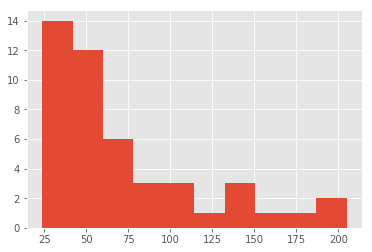

In [2]:
conn = pg.connect(
    host=os.getenv('WMSDB_HOST'),
    database=os.getenv('WMSDB_DB'),
    user=os.getenv('WMSDB_USER'),
    password=os.getenv('WMSDB_PWD')
)
cur = conn.cursor()
cur.execute(f'''
    WITH temp AS (
        SELECT 
            date,
            extract( ISOYEAR FROM date + 1 )::INT2 "year",
            extract( WEEK FROM date + 1 )::INT2 "week",
            CASE WHEN extract( EPOCH FROM start )::DEC % 86400 < 43200
                THEN extract( EPOCH FROM start )::DEC % 86400 + 86400
                ELSE extract( EPOCH FROM start )::DEC % 86400
                END / 60 sst,
            CASE WHEN extract( EPOCH FROM "end" )::DEC % 86400 < 43200
                THEN extract( EPOCH FROM "end" )::DEC % 86400 + 86400
                ELSE extract( EPOCH FROM "end" )::DEC % 86400
                END / 60 "set",
            rem,
            deep,
            asleep,
            awake,
            count(start) OVER ( PARTITION BY extract( ISOYEAR FROM date + 1 ), extract( WEEK FROM date + 1 ) )::INT2 cnt,
            sum(CASE WHEN rem IS NULL THEN 1 ELSE 0 END) 
                OVER ( PARTITION BY extract( ISOYEAR FROM date + 1 ), extract( WEEK FROM date + 1 ) )::INT2 null_cnt

        FROM sleep
        WHERE sj_id = 32
        AND ismain = true
    )    

    SELECT 
        min(date) "start",
        max(date) "end",
        "year",
        "week",
        stddev(sst)::FLOAT4 sst_std,
        stddev("set")::FLOAT4 set_std,
        round( avg( CASE WHEN null_cnt >= 1 THEN NULL ELSE rem END ), 2)::FLOAT4 rem_avg,
        round( avg( CASE WHEN null_cnt >= 1 THEN NULL ELSE deep END ), 2)::FLOAT4 deep_avg,
        round( avg( asleep ), 2)::FLOAT4 asleep_avg,
        round( avg( awake ), 2)::FLOAT4 awake_avg
    FROM temp
    WHERE cnt = 7
    GROUP BY "year", "week"
    ORDER BY "year" ASC, "week" ASC
    ;
''')
records = cur.fetchall()
conn.close()
df = pd.DataFrame(records, columns=[f[0] for f in cur.description])
plt.hist(df['sst_std'], bins=10)

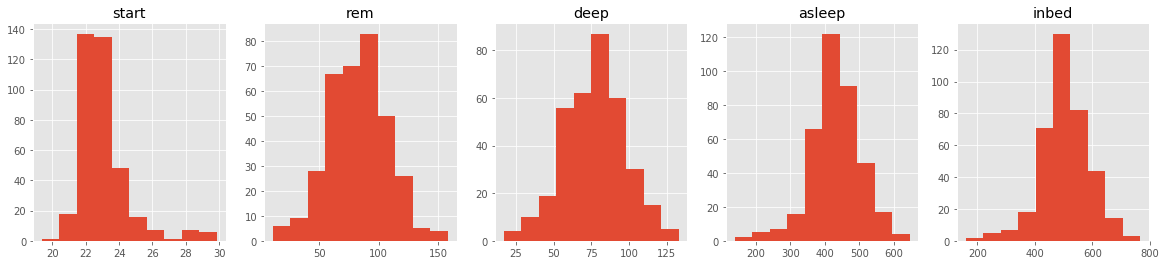

In [28]:
conn = pg.connect(
    host=os.getenv('WMSDB_HOST'),
    database=os.getenv('WMSDB_DB'),
    user=os.getenv('WMSDB_USER'),
    password=os.getenv('WMSDB_PWD')
)
cur = conn.cursor()
cur.execute(f'''
    SELECT
        date,
        CASE WHEN start::TIME BETWEEN TIME '00:00:00' AND TIME '12:00:00' 
            THEN (extract(epoch from start::TIME) + 86400) /3600
            ELSE extract(epoch from start::TIME) /3600
            END "start",
        rem,
        deep,
        asleep,
        inbed
    FROM sleep
    WHERE ismain = true
    AND sj_id = 32;
''')
records = cur.fetchall()
conn.close()
df = pd.DataFrame(records, columns=[f[0] for f in cur.description])
fig, axs = plt.subplots(1,5, figsize=(20,4))
for i, c in enumerate(['start', 'rem', 'deep', 'asleep', 'inbed']):
    axs[i].hist(df.loc[df[c].notna(), c])
    axs[i].set_title(c)

# Get observed sample

In [4]:
sst = df['start'].copy()
print(f'obs_mean: {np.mean(sst)}, obs_std: {np.std(sst)}, obs_size: {sst.shape[0]}')

obs_mean: 23.052100646352716, obs_std: 1.515005105709493, obs_size: 361


sampling_mean: 1.4960137222735557, sampling_std: 0.21131530019287773


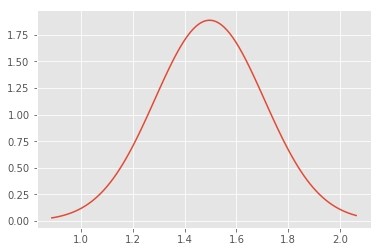

In [42]:
bootstrap_size = 1000
sample_size = 100 # how to determine the proper sample size to ensure the normality of the sampling distribution?

sample_stds = []
for _ in range(bootstrap_size):
    sample = []
    for _ in range(sample_size):
        sample.append(sst[random.randrange(sst.shape[0])])
    sample_stds.append(np.std(sample))

print(f'sampling_mean: {np.mean(sample_stds)}, sampling_std: {np.std(sample_stds)}')
sample_dist = ss.norm(np.mean(sample_stds), np.std(sample_stds))
pdf_xs = np.linspace(min(sample_stds), max(sample_stds), 100)
pdf_ys = [sample_dist.pdf(x) for x in pdf_xs]
# plt.hist(sample_stds)
plt.plot(pdf_xs, pdf_ys)


In [88]:

li = np.percentile(df.loc[df['rem'].notna(), 'rem' ], 25)
ui = np.percentile(df.loc[df['rem'].notna(), 'rem' ], 75)
rg = (ui-li) * 1.5
lo = li - rg
uo = ui + rg
print(f'lower-outlier: {lo}, upper-outlier: {uo}')
df.loc[(df['rem'] >= uo) | (df['rem'] <= lo)].sort_values('date')

lower-outlier: 12.75, upper-outlier: 150.75


,date,start,rem,deep,asleep,inbed
61,2019-03-08,20.741667,152.0,130.0,584,664
160,2019-06-15,28.550000,11.0,55.0,251,293
90,2019-08-26,23.775000,152.0,105.0,562,630
85,2019-08-31,29.866667,12.0,38.0,175,213
266,2019-09-17,29.675000,11.0,17.0,219,276


mean: 23.05, std: 1.49, skew: 2.05, kurt: 5.77
lower outlier bound: 20.23, upper outlier bound: 25.44
number of outliers: 25
mean: 22.75, std: 0.88, skew: 0.36, kurt: 0.12
lower outlier bound: 20.38, upper outlier bound: 25.09
number of outliers: 4
mean: 22.73, std: 0.84, skew: 0.22, kurt: -0.12
lower outlier bound: 20.41, upper outlier bound: 25.03
number of outliers: 0
0.010356311664178365


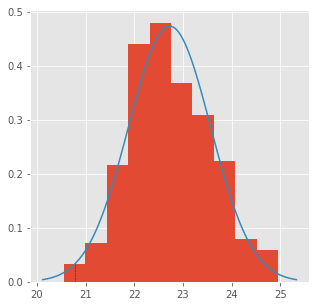

In [8]:
def trunc_outliers(X):
    li = np.percentile(X[X.notna()], 25)
    ui = np.percentile(X[X.notna()], 75)
    rg = (ui-li) * 1.5
    lo = li - rg
    uo = ui + rg
    t = X[(X <= uo) & (X >= lo)].sort_values().copy()
    o = X[(X >= uo) | (X <= lo)].sort_values().copy()
    m, std, s, k = np.mean(X), np.std(X), ss.skew(X), ss.kurtosis(X)
    print(f'''mean: {round(m, 2)}, std: {round(std, 2)}, skew: {round(s,  2)}, kurt: {round(k,2)}''')
    print(f'lower outlier bound: {round(lo, 2)}, upper outlier bound: {round(uo, 2)}')
    print(f'number of outliers: {o.shape[0]}')
    return t, o

def plot_pop_hist(ax, X):
    ax.hist(X, density=True)
    
def plot_pop_norm(ax, dist):
    mi = dist.ppf(0.001)
    ma = dist.ppf(0.999)
    pdf_xs = np.linspace(mi, ma, 100)
    pdf_ys = [dist.pdf(x) for x in pdf_xs]
    ax.plot(pdf_xs, pdf_ys)
    
def plot_rand_value(ax, dist):
    ax.vlines(x, 0, dist.pdf(x), linewidth=0.5, colors='blue', linestyles='dashed')


t = df['start'].copy()
o = df['start'].copy()
while len(o):
    t, o = trunc_outliers(t)


X = t
n = len(X)
m = np.mean(X)
s = np.std(X) * n / (n-1)
dist = ss.norm(m, s)
x = dist.rvs(1)[0]
p = dist.cdf(x) if x < m else 1 - dist.cdf(x)

fig, ax = plt.subplots(1,1, figsize=(5,5))
plot_pop_hist(ax, X)
plot_pop_norm(ax, dist)
plot_rand_value(ax, dist)
print(p)

year: 2020, week: 14 (from 2020-03-30 to 2020-04-05)
stat: sample mean, m: 22.73, se: 0.32, x: 23:06:51, p-value: 0.1113
stat: sample std, m: 0.84, se: 0.32, x: 0.87, p-value: 0.4683


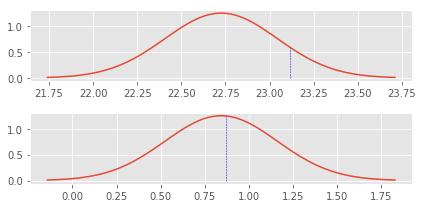

In [49]:
# outliers should only be truncated for estimating the population.
# outliers should not get truncated for samples being tested against the population.

def get_recent_full_week(df, col):
    dates = pd.DataFrame()
    dates['date'] = df.loc[df[col].notna(), 'date'].copy()
    dates['year'] = dates['date'].apply(lambda x: x.isocalendar()[0])
    dates['week'] = dates['date'].apply(lambda x: x.isocalendar()[1])

    dates_grouped = dates.groupby(['year', 'week']).agg('count').reset_index()
    dates_grouped.columns=['year','week','count']
    dates_counted = dates.merge(dates_grouped, on=['year','week'])
    full_weeks = dates_counted.loc[dates_counted['count'] == 7, 'date']
    recent_dates = full_weeks.sort_values()[-7:].values
    return df.loc[df['date'].isin(recent_dates), ['date', col]].copy()

def plot_sampling_dist(ax, dist):
    mi = dist.ppf(0.001)
    ma = dist.ppf(0.999)
    pdf_xs = np.linspace(mi, ma, 100)
    pdf_ys = [dist.pdf(x) for x in pdf_xs]
    ax.plot(pdf_xs, pdf_ys)

def plot_most_recent(ax, dist, x):
    ax.vlines(x, 0, dist.pdf(x), linewidth=0.5, colors='blue', linestyles='dashed')


se = s/np.sqrt(7)
dist = ss.norm(m, se)
rfw = get_recent_full_week(df, 'start')
x = np.mean(rfw['start'])
p = dist.cdf(x) if x < m else 1 - dist.cdf(x)

m_std = np.std(X) * n / (n-1)
s_std = np.std(X) * n / (n-1)
se_std = s_std / np.sqrt(7)
dist_std = ss.norm(m_std, se_std)
x_std = np.std(rfw['start'])
p_std = dist_std.cdf(x_std) if x_std < m_std else 1 - dist_std.cdf(x_std) 

fig, axs = plt.subplots(2,1, figsize=(6,3))
plot_sampling_dist(axs[0], dist)
plot_most_recent(axs[0], dist, x)
plot_sampling_dist(axs[1], dist_std)
plot_most_recent(axs[1], dist_std, x_std)
fig.tight_layout()

yr = rfw['date'].min().isocalendar()[0]
wk = rfw['date'].min().isocalendar()[1]
ws = rfw['date'].min()
we = rfw['date'].max()
x = time.strftime('%H:%M:%S', time.gmtime(x*3600))
print(f"year: {yr}, week: {wk} (from {ws} to {we})")
print(f"stat: sample mean, m: {round(m,2)}, se: {round(se,2)}, x: {x}, p-value: {p:.4}")
print(f"stat: sample std, m: {round(m_std,2)}, se: {round(se_std,2)}, x: {round(x_std,2)}, p-value: {round(p_std,4)}")

